# Generate user, item, and interaction datasets for car search domain
This notebook is one of several provided to demonstrate the use of Amazon Personalize to 
provide recommendations for users searching for cars. This notebook generates the user, item, 
and interactions data, saves them as local csv files, and uploads them to S3 for use
in creating Personalize datasets to drive Personalize recommendation models.

A denormalized form of the interaction data is also saved for use in testing the models
and evaluating the resulting recommendations.

In [110]:
import numpy as np
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [111]:
import boto3

cars_filename         = 'car_items.csv'
users_filename        = 'users.csv'
interactions_filename = 'interactions.csv'
int_exp_filename      = 'interactions_expanded.csv'

bucket   = 'roymark-aws-ml'
prefix   = 'personalize/v10'

## Define size for each generated dataset

In [112]:
NUM_INTERACTIONS = 750000
NUM_CARS         = 50000
NUM_USERS        = 30000

## Define various other parameters

Generated interactions are built as a set of "sessions". Each session is associated with
a single user and multiple car interactions. The timestamp for each interaction is 
separated by a configurable number of seconds.

In [113]:
SESSION_LEN      = 10
SESSION_DELAY_SECONDS = 2 * 60 # 2 minutes

Define other parameters to control metadata for each car item.

In [114]:
MIN_YEAR    = 2009
MAX_YEAR    = 2019
MID_YEAR    = MIN_YEAR + ((MAX_YEAR - MIN_YEAR) // 2)

MIN_MILEAGE = 1000
MAX_MILEAGE = 200000
MILES_PER_YEAR = 15000

COLORS      = ['Red', 'Black', 'White', 'Blue']

In [115]:
MID_YEAR

2014

## Configure the set of car makes and models, plus zip codes

The car item data is driven by a configurable set of models. You can define which
makes and models are used by editing the `models.csv` file provided.

In [116]:
models_df = pd.read_csv('models.csv')
models_df = shuffle(models_df)
print(models_df.shape)

NUM_MODELS = models_df.shape[0]
NUM_CLUSTERS = NUM_MODELS * 2  # for each model, have an old car cluster and new car cluster
models_df.head(NUM_MODELS)

(10, 4)


,MAKE,MODEL,NUM_DOORS,BODY_TYPE
1,Toyota,Sienna,4,minivan
8,Nissan,Rogue,4,suv
7,Nissan,Altima,4,sedan
0,Toyota,Camry,4,sedan
4,Ford,Fusion,4,sedan
6,Ford,Explorer,4,suv
3,Toyota,Prius,4,sedan
9,Nissan,Leaf,4,sedan
5,Ford,Mustang,4,sedan
2,Toyota,Rav4,4,suv


The demo does not fully leverage location data for users and cars, but partial support
is provided in anticipation of adding that to the demo in the future.

In [117]:
zip_codes_df = pd.read_csv('zip_codes.csv')
print(zip_codes_df.shape)
zip_codes_df.head()

(100, 3)


,ZIP_CODE,CITY,INCOME
0,79936,El Paso TX,42857
1,90011,Los Angeles CA,23851
2,60629,Chicago IL,40279
3,90650,Norwalk CA,46012
4,90201,Bell Gardens CA,30029


## Generate data for the cars (items) dataset

### Generate make and model
Here we provide a normal distribution of Make/Model for our generated set of cars.
The mean is the midpoint of the number of total models, and the standard deviation is 
a quarter of the number of models. We make sure that no generated model falls outside the
bounds of the actual number of models.

In [118]:
def gen_normal_make_and_model():
    _idx = int(np.random.normal(NUM_MODELS // 2, NUM_MODELS // 4))
    _idx = min(NUM_MODELS - 1, _idx)
    _idx = max(0, _idx)
    return _idx

### Generate price
Here we determine a random price pased on age and miles.

In [119]:
def gen_price(age, miles):
    _price = 40000 - (3000 * age) + np.random.randint(0, 10000)
    _price = max(10000, _price)
    return _price

### Core function for generating cars (items)
Here we generate the set of items / cars to be recommended. We normally distribute the 
year of manufacture, and generate a random set of miles driven by the age of the car.

In [120]:
def gen_cars(num_cars):
    _car_inventory = []
    
    for i in range(num_cars):
        _year      = int(np.random.normal(2014, 2))
        _year      = min(MAX_YEAR, _year)
        
        _age       = MAX_YEAR - _year
        _mileage   = (MILES_PER_YEAR * _age) + np.random.randint(0, 10000)
        _price     = gen_price(_age, _mileage) 

        _model_idx = gen_normal_make_and_model()
        
#        _color_idx = np.random.randint(0, len(COLORS))
#        _loc_idx   = np.random.randint(0, _zip_len)
        
        _this_car = [str(i), models_df.iloc[_model_idx][0].strip(), 
                     models_df.iloc[_model_idx][1].strip(),
                     str(_year), _mileage, _price]
        #, COLORS[_color_idx], zip_codes_df.iloc[_loc_idx][0]]

        _car_inventory.append(_this_car)

    # not including color and location, due to personalize limit on num fields
    _df = pd.DataFrame(_car_inventory, columns=['ITEM_ID', 'MAKE', 'MODEL', 
                                                'YEAR', 'MILEAGE', 'PRICE'])
    return _df

In [121]:
cars_df = gen_cars(NUM_CARS)
print(cars_df.shape)
cars_df.head()

(50000, 6)


,ITEM_ID,MAKE,MODEL,YEAR,MILEAGE,PRICE
0,0,Nissan,Altima,2015,69411,30351
1,1,Toyota,Camry,2017,38697,42196
2,2,Toyota,Camry,2015,68810,29669
3,3,Nissan,Altima,2015,67221,33381
4,4,Ford,Fusion,2009,151261,11035


In [122]:
cars_df.to_csv(cars_filename, index=False)
boto3.Session().resource('s3').Bucket(bucket).Object('{}/{}'.format(prefix, cars_filename)).upload_file(cars_filename)

### Look at distribution of each car (item) feature

In [123]:
cars_df['MAKE'].value_counts()

Ford      21225
Toyota    17248
Nissan    11527
Name: MAKE, dtype: int64

In [124]:
cars_df['MODEL'].value_counts()

Fusion      9563
Explorer    9432
Prius       7499
Camry       7458
Leaf        4669
Altima      4667
Mustang     2230
Rogue       2191
Rav4        1159
Sienna      1132
Name: MODEL, dtype: int64

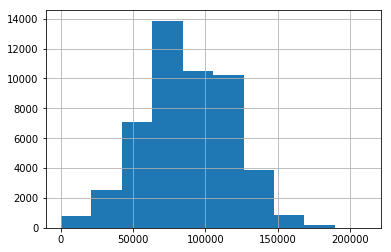

In [125]:
cars_df['MILEAGE'].hist()

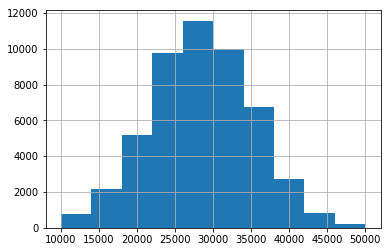

In [126]:
cars_df['PRICE'].hist()

## Generate data for users dataset
Here we normally distribute age of users, and uniformly distribute gender and location.

In [127]:
def gen_users(num_users):
    _users = []
    
    _zip_len = zip_codes_df.shape[0]
    
    for i in range(num_users):
        _age        = int(np.random.normal(40, 4))
        _gender_idx = np.random.randint(0, 2)
        _loc_idx    = np.random.randint(0, _zip_len)
        if _gender_idx == 0:
            _gender = 'MALE'
        else:
            _gender = 'FEMALE'
            
        _this_user = [str(i), _age, _gender, 
                      str(zip_codes_df.iloc[_loc_idx][0]), 
                      zip_codes_df.iloc[_loc_idx][2]]
        
        _users.append(_this_user)
        
    _df = pd.DataFrame(_users, columns=['USER_ID', 'AGE', 'GENDER', 'LOCATION', 'SALARY'])
    return _df

In [128]:
users_df = gen_users(NUM_USERS)
print(users_df.shape)
users_df.head()

(30000, 5)


,USER_ID,AGE,GENDER,LOCATION,SALARY
0,0,33,MALE,11230,32327
1,1,41,FEMALE,90201,30029
2,2,32,MALE,92336,55340
3,3,43,FEMALE,77584,70113
4,4,39,MALE,10458,22072


### Look at the distribution of each user feature

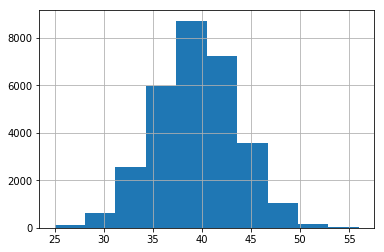

In [129]:
users_df['AGE'].hist()

In [130]:
users_df['LOCATION'].value_counts()[0:10]

926      345
94565    338
77584    336
90805    333
79936    331
10452    331
75211    325
10025    324
95823    324
11235    324
Name: LOCATION, dtype: int64

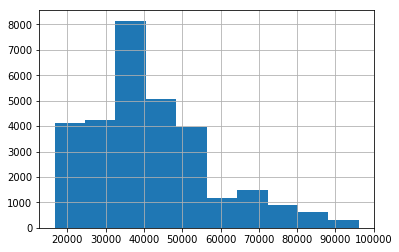

In [131]:
users_df['SALARY'].hist()

In [132]:
users_df.to_csv(users_filename, index=False)
boto3.Session().resource('s3').Bucket(bucket).Object('{}/{}'.format(prefix, users_filename)).upload_file(users_filename)

In [133]:
print('Car count: {}, User count: {}'.format(NUM_CARS, NUM_USERS))

Car count: 50000, User count: 30000


## Generate interactions dataset

### Helper function for normal distribution of interaction items

In [134]:
def gen_normal_item_indices(num_indices, num_items, std_div=10):
    _loc = num_indices // 2
    _std = num_indices // std_div

    _tmp = np.random.normal(loc=_loc, scale=_std, size=num_items)
    _tmp = _tmp.astype(int)

    num_bins = 50
    _a, _b, _c = plt.hist(_tmp, num_bins)
    
    return _tmp

### Add columns to users that will drive a predictable set of interactions
Interactions will be generated on a per-user basis. Here we define what set of cars
a user will be viewing. We do this by defining a set of "car clusters". A car cluster
is the set of cars that all have the same make and model, plus an age preference.
For example, some users will prefer Old Toyota Camry's. Others will like New Ford Explore's.

The `FAV_CLUSTER` feature is an integer representing the user's favorit car cluster. The `FAV` 
feature is a text version that makes it easier to understand the car cluster when looking
at the data during testing and model assessment. These features are NOT saved as part of
the Amazon Personalize datasets, but ARE saved as part of the expanded interactions data
that is saved for helping in the model usage notebook.

9     4028
10    3920
8     3461
11    3439
7     2886
12    2786
13    2026
6     2023
5     1322
14    1300
15     783
4      719
3      389
16     377
2      175
17     156
1       71
18      60
19      41
0       38
Name: FAV_CLUSTER, dtype: int64

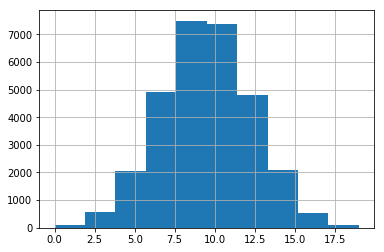

In [135]:
def set_fav(user_id):
    _fav = int(np.random.normal(NUM_CLUSTERS // 2, NUM_CLUSTERS // 6))
    _fav = min(NUM_CLUSTERS - 1, _fav)
    _fav = max(0, _fav)
    return _fav

users_df['FAV_CLUSTER'] = users_df['USER_ID'].apply(set_fav)
users_df['FAV_CLUSTER'].hist()
users_df['FAV_CLUSTER'].value_counts()

4    7489
5    7359
3    4909
6    4812
7    2083
2    2041
1     564
8     533
0     109
9     101
Name: FAV_MODEL, dtype: int64

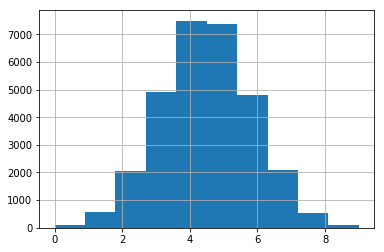

In [136]:
users_df['FAV_MODEL'] = users_df['FAV_CLUSTER'] // 2
users_df['FAV_MODEL'].hist()
users_df['FAV_MODEL'].value_counts()

In [137]:
def set_fav_text(cluster):
    fav_model = cluster // 2
    if cluster % 2 == 0:
        age = 'NEWISH'
    else:
        age = 'OLDISH'
    return  '{}-{}-{}'.format(age,
                              models_df.iloc[fav_model]['MAKE'], 
                              models_df.iloc[fav_model]['MODEL'])
users_df['FAV'] = users_df['FAV_CLUSTER'].apply(set_fav_text)
users_df['FAV'].value_counts()

OLDISH-Ford-Fusion      4028
NEWISH-Ford-Explorer    3920
NEWISH-Ford-Fusion      3461
OLDISH-Ford-Explorer    3439
OLDISH-Toyota-Camry     2886
NEWISH-Toyota-Prius     2786
OLDISH-Toyota-Prius     2026
NEWISH-Toyota-Camry     2023
OLDISH-Nissan-Altima    1322
NEWISH-Nissan-Leaf      1300
OLDISH-Nissan-Leaf       783
NEWISH-Nissan-Altima     719
OLDISH-Nissan-Rogue      389
NEWISH-Ford-Mustang      377
NEWISH-Nissan-Rogue      175
OLDISH-Ford-Mustang      156
OLDISH-Toyota-Sienna      71
NEWISH-Toyota-Rav4        60
OLDISH-Toyota-Rav4        41
NEWISH-Toyota-Sienna      38
Name: FAV, dtype: int64

### Helper functions

In [138]:
def print_item(item_id):
    tmp = cars_df[cars_df.ITEM_ID == item_id].iloc[0]
    print('Id: {}, Make: {}, Model: {}, Miles: {}, Year: {}, Price: {}, Age: {}'.format(item_id,
         tmp['MAKE'], tmp['MODEL'], tmp['MILEAGE'], tmp['YEAR'], tmp['PRICE'], tmp['AGE']))

In [139]:
def print_car_cluster(c):
    print(len(c))
    print(c)

### Generate a normal distribution of random cars for a given car cluster

In [151]:
def gen_normal_from_cluster(_fav_cars, _which_cluster, _sample_size):
    _car_cluster = _fav_cars[_which_cluster]
    _cluster_len = len(_car_cluster)

    _idx_list = np.random.normal(loc=_cluster_len // 2, 
                                 scale=_cluster_len // 10, 
                                 size=_sample_size)
    _idx_list = _idx_list.astype(int)
    
    # We want to maximize how many specific car items are involved in the generated
    # interactions. However, the more we push the envelope, the more likely it is that
    # a generated index is outside of bounds. Here we catch and resolve those situations.
    if max(_idx_list) > (_cluster_len - 1):
#        print('*** idx too big: {}, len: {}'.format(max(_idx_list), _cluster_len))
        _idx_of_max = np.argmax(_idx_list)
        _idx_list[_idx_of_max] = _cluster_len // 2
        new_max = max(_idx_list)
#        print('===== new max is {}'.format(new_max))
        if (new_max > (_cluster_len - 1)):
            _idx_of_max = np.argmax(_idx_list)
            _idx_list[_idx_of_max] = _cluster_len // 2
            new_max = max(_idx_list)
#            print('=====//// new new max is {}'.format(new_max))

    return _car_cluster.iloc[_idx_list]['ITEM_ID'].values

In [168]:
def pick_random_normal_car(car_cluster):
    _cluster_len = car_cluster.shape[0]
    _idx = np.random.normal(loc=_cluster_len // 2,
                            scale=_cluster_len // 10,
                            size=1)
    _item_id = car_cluster.iloc[_idx]['ITEM_ID'].values[0]
    return _item_id

### Core function for generating interactions

In [171]:
def gen_interactions(num_interactions):
    _interactions = []
    
    _num_users = users_df.shape[0]
    _num_items = cars_df.shape[0]
    
    # generate interactions as sets of interactions separated by a few mins
    # by same user on different items
    _session_len = SESSION_LEN
    _num_sessions = num_interactions // _session_len
    print('Generating {} sessions of length {}, total: {}...'.format(_num_sessions, 
                                                                     _session_len,
                                                                     num_interactions))

    # One-time generation of the list of cars that match each possible cluster of
    # favorite cars. A random selection of these will be used in each session.
    _fav_cars = []
    for c in range(NUM_CLUSTERS):
        m = c // 2
        _make  = models_df.iloc[m]['MAKE']
        _model = models_df.iloc[m]['MODEL']
        if c % 2 == 0:
            # newish
            _car_cluster = cars_df[(cars_df.YEAR >= str(MID_YEAR)) &
                                       (cars_df.MAKE  == _make) &
                                       (cars_df.MODEL == _model)]
        else:
            # oldish
            _car_cluster = cars_df[(cars_df.YEAR < str(MID_YEAR)) &
                                       (cars_df.MAKE  == _make) &
                                       (cars_df.MODEL == _model)]

        _fav_cars.append(_car_cluster)

    # Generate a set of user_id's to be used, one per session
    _which_user_idx = gen_normal_item_indices(_num_users, _num_sessions, std_div=6)

    # Session start times will be randomly picked to happen between now and 48 hours ago
    _latest_time   = round(datetime.now().timestamp())
    _earliest_time = _latest_time - (60*48)
    
    for s in range(_num_sessions):
        if (s % 10000 == 0):
            print('...at session {}'.format(s))
            
        _user = _which_user_idx[s]
        
        # ensure user id is within bounds
        if (_user < 0):
            _user = 0
        elif (_user > (NUM_USERS - 1)):
            _user = NUM_USERS - 1
            
        # Use same car cluster for every interaction in the current session
        _which_cluster  = users_df.iloc[_user]['FAV_CLUSTER']

        # Pick a random session start time
        _when = np.random.randint(_earliest_time, _latest_time)
        
        # Generate a set of specific cars to use in this session. Choose them
        # only from the designated car cluster preferred by this user.
        _sample_size = num_interactions // NUM_CLUSTERS
        _session_cars = gen_normal_from_cluster(_fav_cars, _which_cluster, _sample_size)

        for i in range(_session_len):
            interaction_num = (s * _session_len) + i
            idx = interaction_num % NUM_CLUSTERS

            _item = _session_cars[idx]

            _when = _when + (i * SESSION_DELAY_SECONDS) 

            _this_interaction = [str(_user), str(_item), _when]

            _interactions.append(_this_interaction)
        
    _df = pd.DataFrame(_interactions, columns=['USER_ID', 'ITEM_ID', 'TIMESTAMP'])
    return _df

Generating 75000 sessions of length 10, total: 750000...
...at session 0
...at session 10000


KeyboardInterrupt: 

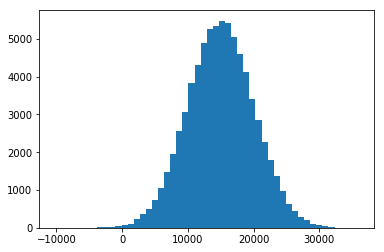

In [172]:
interactions_df = gen_interactions(NUM_INTERACTIONS)
interactions_df.head()

### Show utilization and distribution of interactions per user and per item

In [143]:
_user_vc = interactions_df['USER_ID'].value_counts()
print('{:.2} of users have interactions ({}/{})'.format(_user_vc.shape[0]/NUM_USERS,
                                                        _user_vc.shape[0],
                                                        NUM_USERS))
_user_vc
#interactions_df['USER_ID'].hist()

0.69 of users have interactions (20794/30000)


29999    1110
0        1040
15576     150
14197     150
14565     150
14367     140
15118     140
19720     140
12692     140
14076     140
12817     140
14283     140
12421     140
17345     140
17293     130
15135     130
11334     130
13460     130
17286     130
16106     130
13201     130
14564     130
17100     130
13357     130
17334     130
12566     130
12744     130
12477     130
14201     130
16150     130
         ... 
3751       10
24782      10
1625       10
14340      10
25282      10
20902      10
21359      10
24749      10
28709      10
7148       10
26552      10
22383      10
2812       10
24772      10
1595       10
17467      10
26557      10
22679      10
17538      10
7541       10
25450      10
21675      10
25173      10
6380       10
23682      10
23026      10
28145      10
9568       10
3413       10
29910      10
Name: USER_ID, Length: 20794, dtype: int64

In [144]:
print('{:.2} of ITEMS have interactions ({}/{})'.format(interactions_df['ITEM_ID'].value_counts().shape[0]/NUM_CARS,
                                                      interactions_df['ITEM_ID'].value_counts().shape[0],
                                                       NUM_CARS))
interactions_df['ITEM_ID'].value_counts()
#interactions_df['ITEM_ID'].hist()

0.59 of ITEMS have interactions (29688/50000)


24573    114
26830    113
26135    109
25248    108
26316    108
25478    106
25863    106
27095    105
24231    105
24639    104
25869    104
24831    104
25908    103
25550    102
24270    102
25945    102
25424    101
25045    101
24172    101
23508    100
24143    100
24994    100
24571     99
23483     99
26127     99
24175     99
26753     99
26548     99
26985     98
24354     98
        ... 
4007       1
9012       1
8593       1
40654      1
38200      1
36462      1
39819      1
38813      1
5789       1
12507      1
36994      1
11605      1
8985       1
36432      1
5577       1
39227      1
9088       1
12865      1
40225      1
40505      1
39116      1
8944       1
11540      1
14287      1
38279      1
10666      1
12910      1
38943      1
40979      1
41978      1
Name: ITEM_ID, Length: 29688, dtype: int64

### Create an expanded interactions dataframe for analysis
The interactions dataframe to pass to Personalize is limited to 5 metadata items
and is conforming to a schema we will define in another notebook. This expanded 
dataframe helps with framing tests and evaluating results, as in creates one big
denormalized dataframe with interactions and corresponding user and car features.

In [145]:
interactions_expanded_df = pd.merge(interactions_df, cars_df, on='ITEM_ID')
interactions_expanded_df = pd.merge(interactions_expanded_df, users_df, on='USER_ID')
interactions_expanded_df.head()

,USER_ID,ITEM_ID,TIMESTAMP,MAKE,MODEL,YEAR,MILEAGE,PRICE,AGE,GENDER,LOCATION,SALARY,FAV_CLUSTER,FAV_MODEL,FAV
0,14776,23175,1562854213,Ford,Explorer,2011,126409,17973,32,MALE,75070,84847,11,5,OLDISH-Ford-Explorer
1,14776,22013,1562854333,Ford,Explorer,2013,91403,24385,32,MALE,75070,84847,11,5,OLDISH-Ford-Explorer
2,14776,29493,1562854573,Ford,Explorer,2013,93427,25676,32,MALE,75070,84847,11,5,OLDISH-Ford-Explorer
3,14776,21311,1562854933,Ford,Explorer,2010,144867,18469,32,MALE,75070,84847,11,5,OLDISH-Ford-Explorer
4,14776,31942,1562855413,Ford,Explorer,2013,98956,27412,32,MALE,75070,84847,11,5,OLDISH-Ford-Explorer


### Save interactions to S3 and expanded interactions to local csv

In [146]:
interactions_df.to_csv(interactions_filename, index=False)
boto3.Session().resource('s3').Bucket(bucket).Object('{}/{}'.format(prefix, interactions_filename)).upload_file(interactions_filename)

In [147]:
interactions_expanded_df.to_csv(int_exp_filename, index=False)